## 3. 模型训练
模型的训练主要分为两个部分：
1. Lip-Sync Expert Discriminator的训练。这里提供官方的预训练模型 [weight](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/radrabha_m_research_iiit_ac_in/EQRvmiZg-HRAjvI6zqN9eTEBP74KefynCwPWVmF57l-AYA?e=ZRPHKP)
2. Wav2Lip 模型的训练。

### 3.1 预训练Lip-Sync Expert
#### 1. 网络的搭建 
上面我们已经介绍了SyncNet的基本网络结构，主要有一系列的(Conv+BatchNorm+Relu)组成，这里我们对其进行了一些改进，加入了残差结构。为了方便之后的使用，我们对(Conv+BatchNorm+Relu)以及残差模块进行了封装。

# Define Models

## These are models from Wav2lip project

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

### Conv2d

In [2]:
class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

### nonorm_Conv2d

In [3]:
class nonorm_Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            )
        self.act = nn.LeakyReLU(0.01, inplace=True)

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

### Conv2dTranspose

In [4]:
class Conv2dTranspose(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

SyncNet from Wav2Lip project

In [5]:
class SyncNet_color(nn.Module):
    def __init__(self):
        super(SyncNet_color, self).__init__()
        
        ################TODO###################
        #根据上面提供的网络结构图，补全下面卷积网络的参数

        self.face_encoder = nn.Sequential(
            Conv2d(15, 32, kernel_size=(7, 7), stride=1, padding=3),

            Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

    def forward(self, audio_sequences, face_sequences): # audio_sequences := (B, dim, T)
        
        #########################TODO#######################
        # 正向传播
        face_embedding = self.face_encoder(face_sequences)
        audio_embedding = self.audio_encoder(audio_sequences)

        audio_embedding = audio_embedding.view(audio_embedding.size(0), -1)
        face_embedding = face_embedding.view(face_embedding.size(0), -1)

        audio_embedding = F.normalize(audio_embedding, p=2, dim=1)
        face_embedding = F.normalize(face_embedding, p=2, dim=1)


        return audio_embedding, face_embedding

Wav2lip file


In [6]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class Wav2Lip(nn.Module):
    def __init__(self):
        super(Wav2Lip, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(6, 16, kernel_size=7, stride=1, padding=3)), # 96,96

            nn.Sequential(Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 48,48
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 24,24
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 12,12
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(128, 256, kernel_size=3, stride=2, padding=1),       # 6,6
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(256, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),
            
            nn.Sequential(Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.face_decoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(512, 512, kernel_size=1, stride=1, padding=0),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=1, padding=0), # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),), # 6, 6

            nn.Sequential(Conv2dTranspose(768, 384, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),), # 12, 12

            nn.Sequential(Conv2dTranspose(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),), # 24, 24

            nn.Sequential(Conv2dTranspose(320, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),), # 48, 48

            nn.Sequential(Conv2dTranspose(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),),]) # 96,96

        self.output_block = nn.Sequential(Conv2d(80, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()) 

    def forward(self, audio_sequences, face_sequences):
        # audio_sequences = (B, T, 1, 80, 16)
        B = audio_sequences.size(0)

        input_dim_size = len(face_sequences.size())
        if input_dim_size > 4:
            audio_sequences = torch.cat([audio_sequences[:, i] for i in range(audio_sequences.size(1))], dim=0)
            face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)

        audio_embedding = self.audio_encoder(audio_sequences) # B, 512, 1, 1

        feats = []
        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)
            feats.append(x)

        x = audio_embedding
        for f in self.face_decoder_blocks:
            x = f(x)
            try:
                x = torch.cat((x, feats[-1]), dim=1)
            except Exception as e:
                print(x.size())
                print(feats[-1].size())
                raise e
            
            feats.pop()

        x = self.output_block(x)

        if input_dim_size > 4:
            x = torch.split(x, B, dim=0) # [(B, C, H, W)]
            outputs = torch.stack(x, dim=2) # (B, C, T, H, W)

        else:
            outputs = x
            
        return outputs

class Wav2Lip_disc_qual(nn.Module):
    def __init__(self):
        super(Wav2Lip_disc_qual, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(nonorm_Conv2d(3, 32, kernel_size=7, stride=1, padding=3)), # 48,96

            nn.Sequential(nonorm_Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=2), # 48,48
            nonorm_Conv2d(64, 64, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(64, 128, kernel_size=5, stride=2, padding=2),    # 24,24
            nonorm_Conv2d(128, 128, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(128, 256, kernel_size=5, stride=2, padding=2),   # 12,12
            nonorm_Conv2d(256, 256, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(256, 512, kernel_size=3, stride=2, padding=1),       # 6,6
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),

            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1),),
            
            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            nonorm_Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.binary_pred = nn.Sequential(nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0), nn.Sigmoid())
        self.label_noise = .0

    def get_lower_half(self, face_sequences):
        return face_sequences[:, :, face_sequences.size(2)//2:]

    def to_2d(self, face_sequences):
        B = face_sequences.size(0)
        face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)
        return face_sequences

    def perceptual_forward(self, false_face_sequences):
        false_face_sequences = self.to_2d(false_face_sequences)
        false_face_sequences = self.get_lower_half(false_face_sequences)

        false_feats = false_face_sequences
        for f in self.face_encoder_blocks:
            false_feats = f(false_feats)

        false_pred_loss = F.binary_cross_entropy(self.binary_pred(false_feats).view(len(false_feats), -1), 
                                        torch.ones((len(false_feats), 1)).cuda())

        return false_pred_loss

    def forward(self, face_sequences):
        face_sequences = self.to_2d(face_sequences)
        face_sequences = self.get_lower_half(face_sequences)

        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)

        return self.binary_pred(x).view(len(x), -1)


In [7]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

# from models import SyncNet_color as SyncNet
import Wav2Lip.audio as audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
# from Wav2Lip.hparams import hparams, get_image_list
from Wav2Lip.hparams import hparams

## Define Dataset

In [25]:
global_step = 0 #起始的step
global_epoch = 0 #起始的epoch
device = "mps" if torch.backends.mps.is_built() else torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
use_cuda = False
syncnet_T = 5 ## 每次选取200ms的视频片段进行训练，视频的fps为25，所以200ms对应的帧数为：25*0.2=5帧
syncnet_mel_step_size = 16 # 200ms对应的声音的mel-spectrogram特征的长度为16.
data_root="../Data_Collection/lrs2_preprocessed/" #数据集的位置

Using mps device


In [9]:
def get_image_list(data_root, split):
	filelist = []

	with open('../Data_Collection/lrs2_preprocessed/filelists/{}.txt'.format(split)) as f:
		for line in f:
			line = line.strip()
			if ' ' in line: line = line.split()[0]
			filelist.append(os.path.join(data_root, line))

	return filelist

In [10]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def crop_audio_window(self, spec, start_frame):
        # num_frames = (T x hop_size * fps) / sample_rate
        start_frame_num = self.get_frame_id(start_frame)
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))

        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]


    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        return: x,mel,y
        x: 五张嘴唇图片
        mel: 对应的语音的mel spectrogram
        t: 同步or不同步
        
        """
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]

            img_names = list(glob(join(vidname, '*.jpg')))
            # print(len(img_names))
            if len(img_names) <= 3 * syncnet_T:
                continue
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)
            
            
            #随机决定是产生负样本还是正样本
            if random.choice([True, False]):
                y = torch.ones(1).float()
                chosen = img_name
            else:
                y = torch.zeros(1).float()
                chosen = wrong_img_name

            window_fnames = self.get_window(chosen)
            if window_fnames is None:
                continue

            window = []
            all_read = True
            for fname in window_fnames:
                img = cv2.imread(fname)
                if img is None:
                    all_read = False
                    break
                try:
                    img = cv2.resize(img, (hparams.img_size, hparams.img_size))
                except Exception as e:
                    all_read = False
                    break

                window.append(img)

            if not all_read: continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)

            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            # H x W x 3 * T
            x = np.concatenate(window, axis=2) / 255.
            x = x.transpose(2, 0, 1)
            x = x[:, x.shape[1]//2:]

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)

            return x, mel, y

# Read all data

### Need update audio.py line 100 for latest librosa

In [11]:
ds=Dataset("train")
x,mel,t=ds[0]
print(x.shape)
print(mel.shape)
print(t.shape)


torch.Size([15, 48, 96])
torch.Size([1, 80, 16])
torch.Size([1])


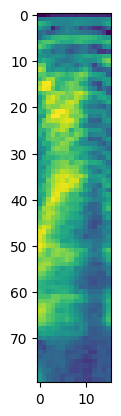

In [12]:
import matplotlib.pyplot as plt
plt.imshow(mel[0].numpy())

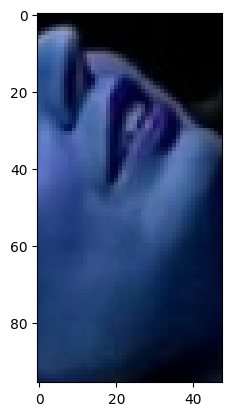

In [13]:
plt.imshow(x[:3,:,:].transpose(0,2).numpy())

# Train

In [14]:
#损失函数的定义
logloss = nn.BCELoss() # 交叉熵损失
def cosine_loss(a, v, y):#余弦相似度损失
    """
    a: audio_encoder的输出
    v: video face_encoder的输出
    y: 是否同步的真实值
    """
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

In [20]:
def train(device, model, train_data_loader, test_data_loader, optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):

    global global_step, global_epoch
    resumed_step = global_step
    
    while global_epoch < nepochs:
        running_loss = 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, mel, y) in prog_bar:
            model.train()
            optimizer.zero_grad()

            #####TODO###########
            ####################
            #补全模型的训练
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            loss.backward()
            optimizer.step()
                
            

            global_step += 1
            cur_session_steps = global_step - resumed_step
            running_loss += loss.item()

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)

            if global_step % hparams.syncnet_eval_interval == 0:
                with torch.no_grad():
                    eval_model(test_data_loader, global_step, device, model, checkpoint_dir)

            prog_bar.set_description('Epoch: {} Loss: {}'.format(global_epoch, running_loss / (step + 1)))

        global_epoch += 1

def eval_model(test_data_loader, global_step, device, model, checkpoint_dir):
    #在测试集上进行评估
    eval_steps = 1400
    print('Evaluating for {} steps'.format(eval_steps))
    losses = []
    while 1:
        for step, (x, mel, y) in enumerate(test_data_loader):

            model.eval()

            # Transform data to CUDA device
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            losses.append(loss.item())

            if step > eval_steps: break

        averaged_loss = sum(losses) / len(losses)
        print(averaged_loss)

        return

latest_checkpoint_path = ''
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch):
    #保存训练的结果 checkpoint
    global latest_checkpoint_path
    
    checkpoint_path = join(
        checkpoint_dir, "checkpoint_step{:09d}.pth".format(global_step))
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    latest_checkpoint_path = checkpoint_path
    print("Saved checkpoint:", checkpoint_path)

def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_checkpoint(path, model, optimizer, reset_optimizer=False):
    #读取指定checkpoint的保存信息
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    model.load_state_dict(checkpoint["state_dict"])
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    global_step = checkpoint["global_step"]
    global_epoch = checkpoint["global_epoch"]

    return model

In [26]:
checkpoint_dir = "checkpoints/expert_checkpoints/" #指定存储 checkpoint的位置
checkpoint_path = 'checkpoints/expert_checkpoints/checkpoint_step000080000.pth'
# 指定加载checkpoint的路径，第一次训练时不需要，后续如果想从某个checkpoint恢复训练，可指定。

if not os.path.exists(checkpoint_dir): os.mkdir(checkpoint_dir)

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

############TODO#########
#####Train Dataloader and Test Dataloader 
#### 具体的bacthsize等参数，参考 hparams.py文件
train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=8)

# Model
#####定义 SynNet模型，并加载到指定的device上
model = SyncNet_color().to(device)
print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

####定义优化器，使用adam，lr参考hparams.py文件
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=1e-5)

if checkpoint_path is not None:
    load_checkpoint(checkpoint_path, model, optimizer, reset_optimizer=True)

train(device, model, train_data_loader, test_data_loader, optimizer,
      checkpoint_dir=checkpoint_dir,
      checkpoint_interval=hparams.syncnet_checkpoint_interval,
      nepochs=27)

total trainable params 16435072
Load checkpoint from: checkpoints/expert_checkpoints/checkpoint_step000080000.pth


/var/folders/pm/x83zrlkn551fhsmr72ncx8yw0000gn/T/ipykernel_79811/3162096508.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.